In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr

from model import make_model, sample_model, plot_forestplots

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [2]:
def make_simulated_data(n_reps_low, n_reps_high, n_genotypes):
    means = npr.randint(low=10, high=100, size=n_genotypes)
    means = means * (means > 0)  # negative activities are not captured
    sds = npr.random(size=n_genotypes) * 10
    num_measurements = npr.randint(low=n_reps_low, high=n_reps_high, size=n_genotypes)

    # Create simulated data.
    data = []
    indices = []

    for i in range(n_genotypes):
        n = num_measurements[i]
        mean = means[i]
        sd = sds[i]

        measurements = npr.normal(loc=mean, scale=sd, size=n)
        # print(measurements)
        measurements = measurements * (measurements > 0)
        # print(measurements)

        data.extend(measurements.tolist())
        indices.extend([i] * n)

    # Add baseline measurements (bl_measures)
    n_bl_measures = n_reps_high - 1
    bl_measures = npr.normal(loc=1.0, scale=0.1, size=n_bl_measures)
    bl_measures = bl_measures * (bl_measures > 0)
    data.extend(bl_measures)
    indices.extend([n_genotypes] * n_bl_measures)
    num_measurements = np.append(num_measurements, n_bl_measures)
    means = np.append(means, bl_measures.mean())
    sds = np.append(sds, bl_measures.std())

    # Add pos_ctrl measurements (pc_measures)
    n_pc_measures = n_reps_high - 1
    pc_measures = npr.normal(loc=20.0, scale=1, size=n_pc_measures)
    pc_measures = pc_measures * (pc_measures > 0)
    data.extend(pc_measures)
    indices.extend([n_genotypes + 1] * n_pc_measures)
    num_measurements = np.append(num_measurements, n_pc_measures)
    means = np.append(means, pc_measures.mean())
    sds = np.append(sds, pc_measures.std())

    # convert indices to a numpy array
    indices = np.array(indices)

    return data, indices, num_measurements, means, sds,

In [3]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 10
n_reps_low = 2
n_reps_high = 11

sim_data = make_simulated_data(n_genotypes=n_genotypes, n_reps_low=n_reps_low, n_reps_high=n_reps_high)
data, indices, num_measurements, means, sds = sim_data

In [4]:
# Compute the "actual" Z'-factor for the assay.
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.88661445913857673

In [5]:
model = make_model(n_genotypes, data, indices)

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [6]:
%%time
trace = sample_model(model, n_genotypes)

Iteration 0 [0%]: ELBO = -618.38
Iteration 20000 [10%]: Average ELBO = -465.16
Iteration 40000 [20%]: Average ELBO = -290.97
Iteration 60000 [30%]: Average ELBO = -267.3
Iteration 80000 [40%]: Average ELBO = -265.11
Iteration 100000 [50%]: Average ELBO = -257.71
Iteration 120000 [60%]: Average ELBO = -239.95
Iteration 140000 [70%]: Average ELBO = -227.64
Iteration 160000 [80%]: Average ELBO = -213.6
Iteration 180000 [90%]: Average ELBO = -213.01
Finished [100%]: Average ELBO = -212.94
CPU times: user 26.3 s, sys: 491 ms, total: 26.8 s
Wall time: 27.5 s


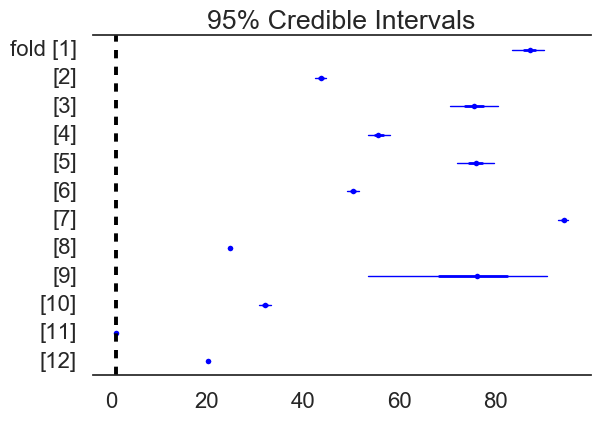

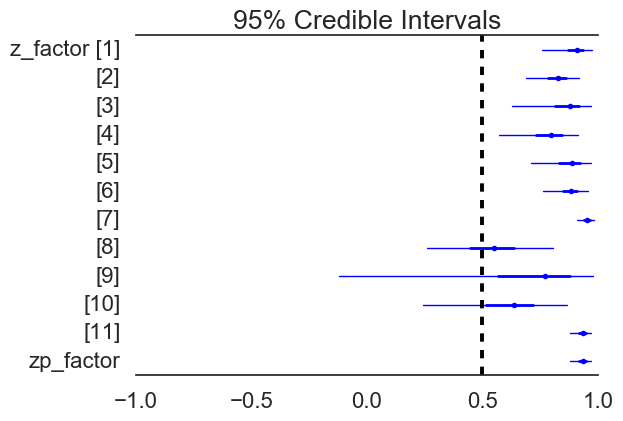

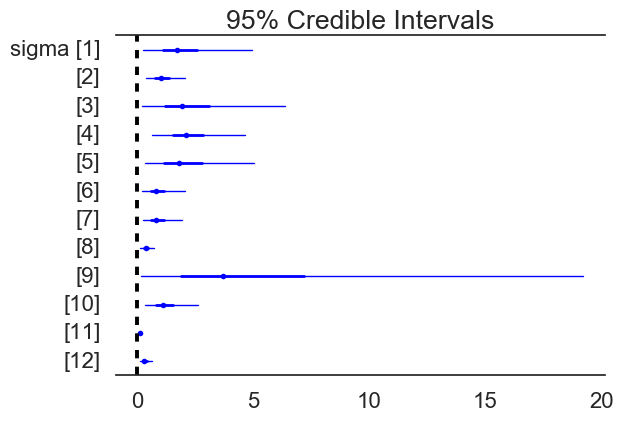

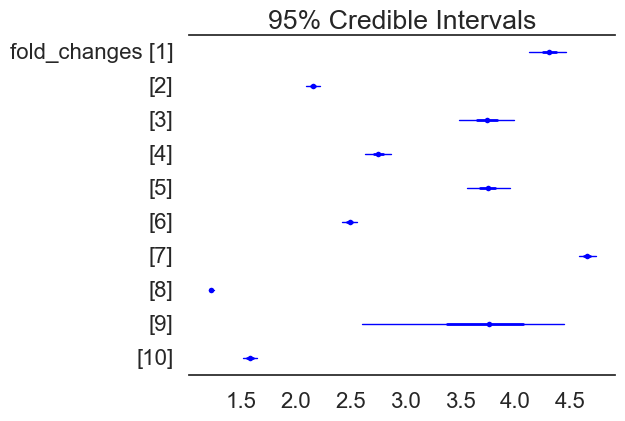

In [7]:
if n_genotypes <= 15:
    plot_forestplots(trace)

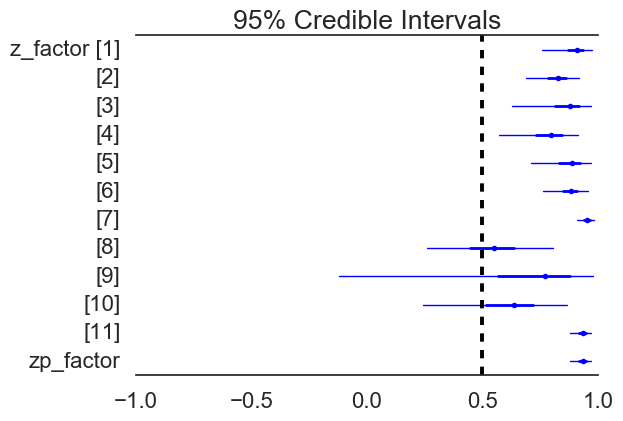

In [8]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['z_factor', 'zp_factor'], vline=0.5)
    plt.xlim(-1, 1)
    plt.savefig('../figures/z-factor_sim.pdf', bbox_inches='tight')

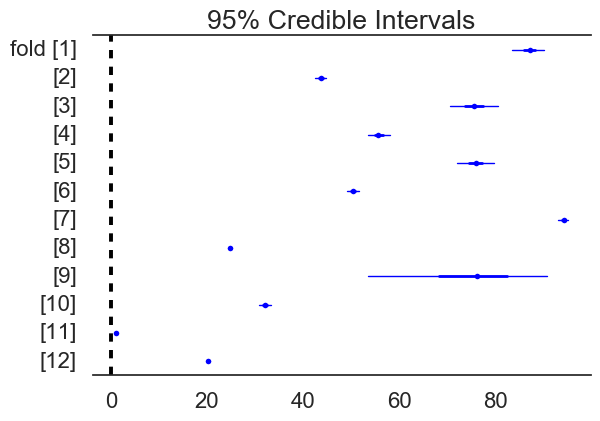

In [9]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold'])
    plt.savefig('../figures/foldchange.pdf', bbox_inches='tight')

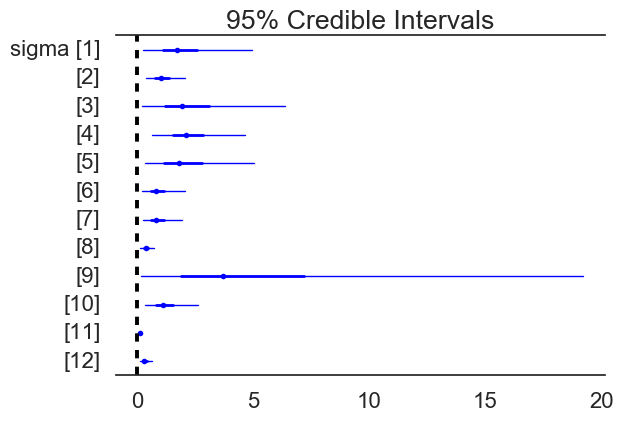

In [10]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['sigma'])
    plt.savefig('../figures/sigma.pdf', bbox_inches='tight')

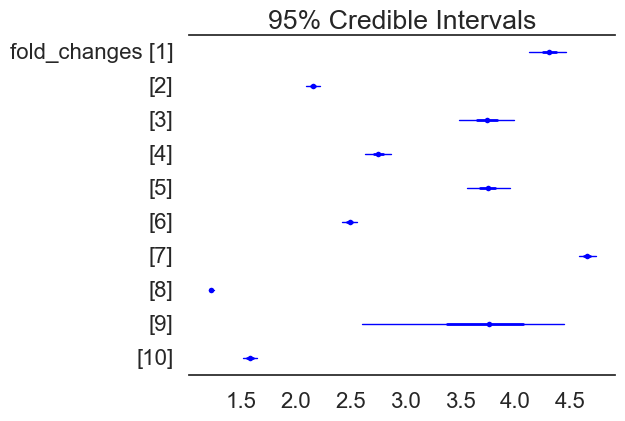

In [11]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold_changes'])
    plt.savefig('../figures/fold_changes.pdf', bbox_inches='tight')

In [12]:
if n_genotypes <= 15:
    pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  94.974           0.291            0.007            [94.454, 95.571]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  94.396         94.774         94.974         95.180         95.531


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  87.073           1.732            0.039            [83.511, 90.087]
  43.643           0.569            0.013            [42.466, 44.683]
  75.530           2.666            0.060            [70.486, 80.628]
  55.674           1.226            0.024            [53.387, 58.019]
  75.782           1.964            0.047            [72.092, 79.686]
  50.329           0.641            0.013        

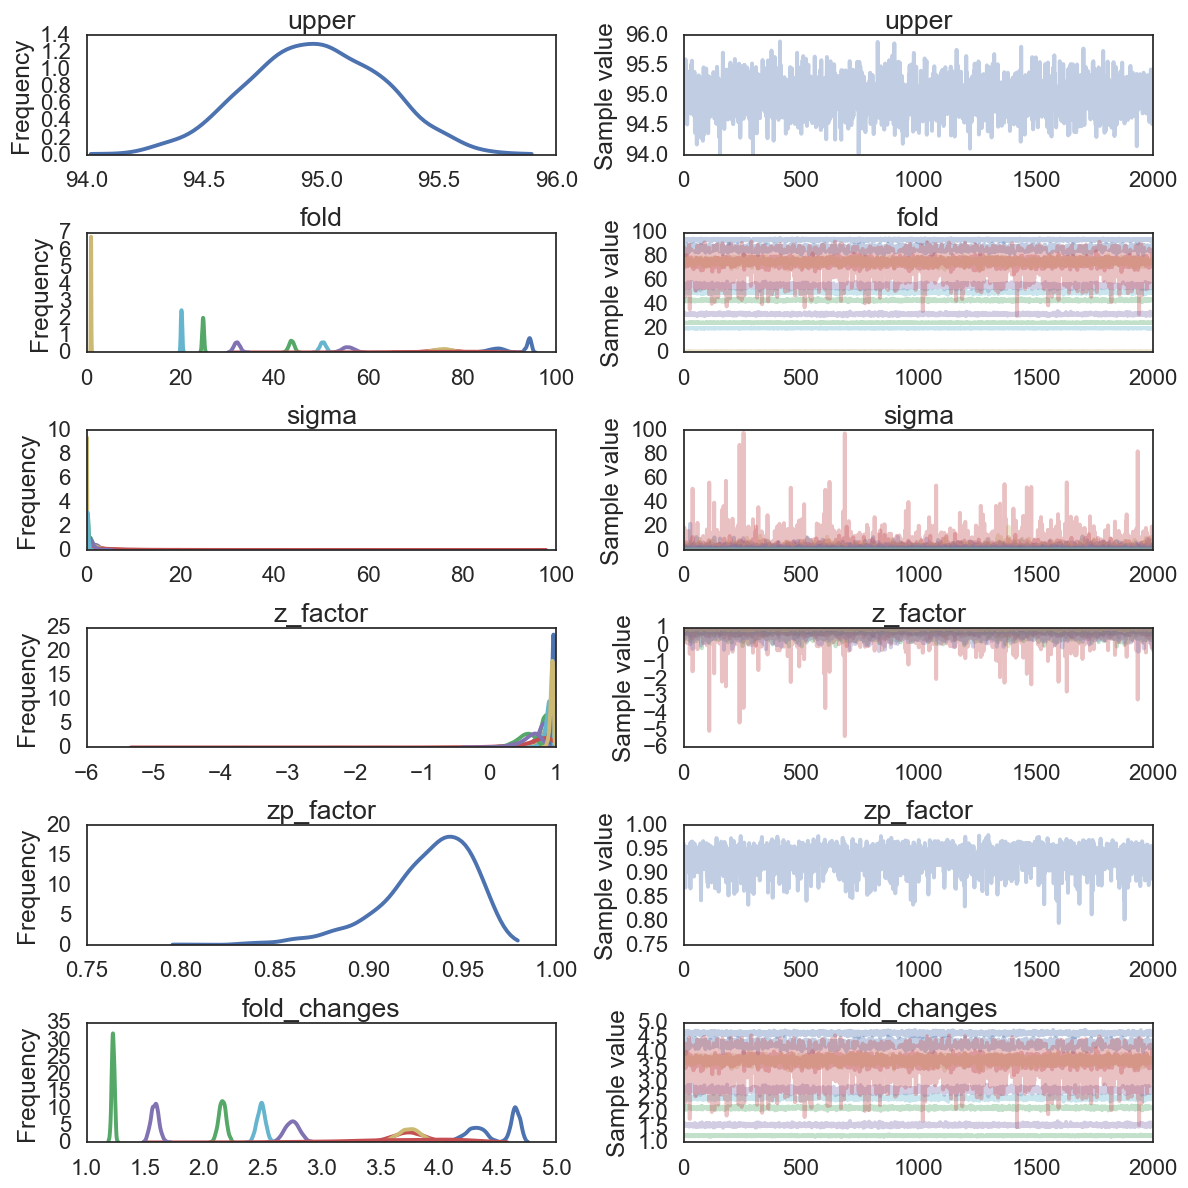

In [13]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [14]:
num_measurements

array([ 4, 10,  3,  9,  4,  6,  8, 10,  2,  7, 10, 10])

In [15]:
trace['fold'].mean(axis=0) - means

array([ 0.07340288,  0.64294112,  3.52982943,  0.67375858, -3.21807092,
       -0.6707469 , -0.83937632, -0.17362664, -3.62580626,  1.02526862,
       -0.01643462,  0.1772325 ])

In [16]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,4.0,0.073403
1,10.0,0.642941
2,3.0,3.529829
3,9.0,0.673759
4,4.0,-3.218071


In [17]:
if n_genotypes >= 500 and n_reps_high - n_reps_low > 1:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    # plt.xticks(x=sorted(list(set(errors_df['num_measurements']))), )
    plt.xticks(rotation=90)
    plt.ylabel('Error in Fold Change')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/error-means.pdf', bbox_inches='tight')
    
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('Variance in Error')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/var-error-means.pdf', bbox_inches='tight')

In [18]:
(trace['fold'].mean(axis=0) - means).mean()

-0.2018023760862129

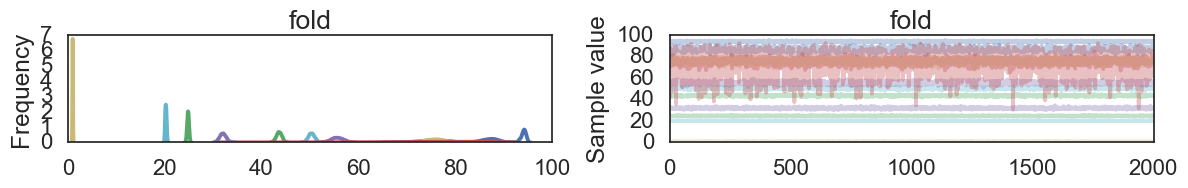

In [19]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()

# Compare modelled to actual

In [20]:
trace['fold'].mean(axis=0)

array([ 87.07340288,  43.64294112,  75.52982943,  55.67375858,
        75.78192908,  50.3292531 ,  94.16062368,  24.82637336,
        74.37419374,  32.02526862,   0.96712329,  20.23730302])

In [21]:
trace['fold'].mean(axis=0).shape

(12,)

In [22]:
np.arange(1, n_genotypes+3).shape

(12,)

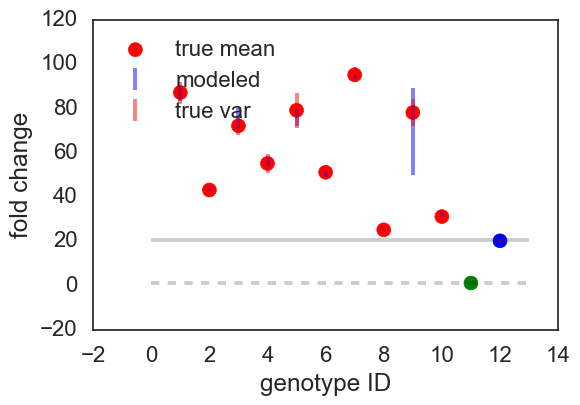

In [23]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

just for checking the above plot...


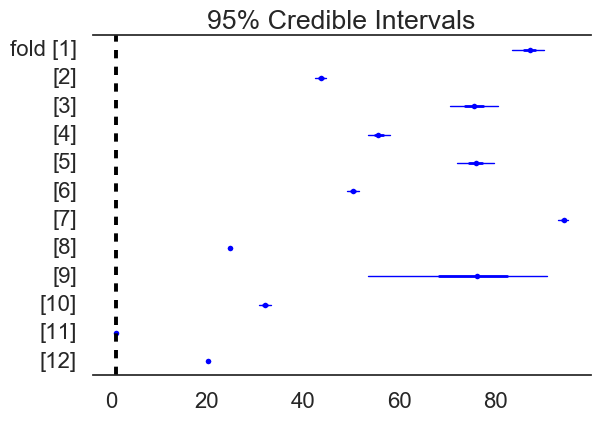

In [24]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

## How often is the true mean inside the 95% HPD?

In [25]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
lower, upper

(array([ 83.32051258,  42.49489   ,  69.98993703,  53.31729813,
         71.72491327,  49.06849229,  92.98489723,  24.44268866,
         49.82310281,  30.75121666,   0.86097174,  19.96037212]),
 array([ 89.98513902,  44.73448129,  80.23030439,  58.00453365,
         79.46978455,  51.54405526,  95.00717296,  25.21710625,
         89.12655582,  33.37679893,   1.09008544,  20.53217398]))

In [26]:
means

array([ 87.        ,  43.        ,  72.        ,  55.        ,
        79.        ,  51.        ,  95.        ,  25.        ,
        78.        ,  31.        ,   0.98355791,  20.06007052])

In [27]:
# Here is the fraction of means that have been correctly included within the 95% HPD.
sum((means > lower) *  (means < upper)) / len(means)

1.0

## What is the distribution of SEM vs. 95% CI vs. Bayesian 95% HPD?

In [28]:
if n_genotypes >= 500 and n_reps_high - n_reps_low == 1:
    df = pd.DataFrame()
    df['measurements'] = data
    df['indices'] = indices
    df.groupby('indices').std()

    errorbars = pd.DataFrame()
    errorbars['SEM'] = 2 * df.groupby('indices').std()['measurements'] / np.sqrt(num_measurements)
    errorbars['Frequentist'] = 1.96 * errorbars['SEM']
    errorbars['Bayesian'] = upper - lower
    errorbars['Data'] = df.groupby('indices')['measurements'].max() - df.groupby('indices')['measurements'].min()
    # errorbars['Data'] = df.groupby('indices')['measurements'].var

    alpha = 0.4
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    # ax.set_aspect('equal')
    ax.scatter(x=errorbars['Data'], y=errorbars['Frequentist'], color='red', label='Frequentist 95% CI', alpha=alpha)
    ax.scatter(x=errorbars['Data'], y=errorbars['Bayesian'], color='blue', label='Bayesian 95% CI', alpha=alpha)
    ax.scatter(x=errorbars['Data'], y=errorbars['SEM'], color='green', label='Std. Err. Mean', alpha=alpha)

    lims = [
        0,  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]) - 10,  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.legend(loc='upper left')
    ax.set_ylabel('Interval Width')
    ax.set_xlabel('Data Range (Max - Min)')
    plt.savefig('../figures/simulation-range-estimates.pdf', bbox_inches='tight')